This notebook will show the bare bones API for pruning circuits. We will get circuits that lead all the way to output units for specific categories in Imagenet trained alexnet. We can then see how those categories functionally overlap.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#well load general packages here, 
#API specific functions will be loaded right before they are used, so you can see where they come from

import torch
import numpy as np
from PIL import Image
from collections import OrderedDict
import numpy as np


### Model
with this API, you should be able to specify pretty much any Pytorch model

In [3]:
device = 'cuda:0'

from torchvision.models import resnet18, alexnet

#model = resnet18(pretrained=True)
model = alexnet(pretrained=True)
_ = model.to(device).eval()


/home/chris/miniconda3/envs/circuit_pruner/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


### Data

circuit pruning will always require a data loader. A circuit will be pruned 'with respect to' that dataloader; i.e. it will return a circuit responsible for a target features response to images from that dataloader. For this demo, we will use the imagenet validation set, as more of you are likely to have that data. In practice, this is 50000 images, and you can probably get away with using much fewer, speeding up everything proportionally.

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


data_folder_path = '/mnt/data/datasets/imagenet/val/'

preprocess =  transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

kwargs = {'num_workers': 4, 'pin_memory': True, 'sampler':None} if 'cuda' in device else {}

dataloader = DataLoader(ImageFolder(data_folder_path,transform=preprocess),
                                         batch_size=64,
                                         shuffle=False,
                                         **kwargs)

from circuit_pruner.utils import load_config
from circuit_pruner.data_loading import rank_image_data

config_file = './configs/alexnet_sparse_config.py'

config = load_config(config_file)

dataloader = torch.utils.data.DataLoader(rank_image_data(config.data_path,
                                        config.preprocess,
                                        label_file_path = config.label_file_path,class_folders=True),
                                        batch_size=64,
                                        shuffle=False,
                                        **kwargs)




### Feature Target
Pruning a circuit requires specifying a 'target'. A target requires to things; a string 'layer_name', and an int specifying the target unit in that layer, or a list-like object the length of the target layer specifying coefficients.

#### layer

In [5]:
#get all possible layer names as dictionary keys, the value of which is the corresponding layer
layers = OrderedDict([*model.named_modules()])

layers.keys()

odict_keys(['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'])

In [6]:
layers['features.0']

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [7]:
#we want to target the final output layer for our experiment, 
#although any layer name listed above would be a valid argument for the following API.

target_layer = list(layers.keys())[-1]
print(target_layer)

classifier.6


#### unit

To specify our 'unit' it will be useful to consider the categories associated with each position of the target vector. We've put them in a list below. We can thus index the list to get a unit for that target

In [8]:
category_targets = ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'rooster', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 'sidewinder', 'trilobite', 'harvestman', 'scorpion', 'black_and_gold_garden_spider', 'barn_spider', 'garden_spider', 'black_widow', 'tarantula', 'wolf_spider', 'tick', 'centipede', 'black_grouse', 'ptarmigan', 'ruffed_grouse', 'prairie_chicken', 'peacock', 'quail', 'partridge', 'African_grey', 'macaw', 'sulphur_crested_cockatoo', 'lorikeet', 'coucal', 'bee_eater', 'hornbill', 'hummingbird', 'jacamar', 'toucan', 'drake', 'red_breasted_merganser', 'goose', 'black_swan', 'tusker', 'echidna', 'platypus', 'wallaby', 'koala', 'wombat', 'jellyfish', 'sea_anemone', 'brain_coral', 'flatworm', 'nematode', 'conch', 'snail', 'slug', 'sea_slug', 'chiton', 'chambered_nautilus', 'Dungeness_crab', 'rock_crab', 'fiddler_crab', 'king_crab', 'American_lobster', 'spiny_lobster', 'crayfish', 'hermit_crab', 'isopod', 'white_stork', 'black_stork', 'spoonbill', 'flamingo', 'little_blue_heron', 'American_egret', 'bittern', 'crane_bird', 'limpkin', 'European_gallinule', 'American_coot', 'bustard', 'ruddy_turnstone', 'red_backed_sandpiper', 'redshank', 'dowitcher', 'oystercatcher', 'pelican', 'king_penguin', 'albatross', 'grey_whale', 'killer_whale', 'dugong', 'sea_lion', 'Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih_Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black_and_tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire_haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft_coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat_coated_retriever', 'curly_coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'German_short_haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'dalmatian', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan_corgi', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'timber_wolf', 'white_wolf', 'red_wolf', 'coyote', 'dingo', 'dhole', 'African_hunting_dog', 'hyena', 'red_fox', 'kit_fox', 'Arctic_fox', 'grey_fox', 'tabby', 'tiger_cat', 'Persian_cat', 'Siamese_cat', 'Egyptian_cat', 'cougar', 'lynx', 'leopard', 'snow_leopard', 'jaguar', 'lion', 'tiger', 'cheetah', 'brown_bear', 'American_black_bear', 'ice_bear', 'sloth_bear', 'mongoose', 'meerkat', 'tiger_beetle', 'ladybug', 'ground_beetle', 'long_horned_beetle', 'leaf_beetle', 'dung_beetle', 'rhinoceros_beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'cricket', 'walking_stick', 'cockroach', 'mantis', 'cicada', 'leafhopper', 'lacewing', 'dragonfly', 'damselfly', 'admiral', 'ringlet', 'monarch', 'cabbage_butterfly', 'sulphur_butterfly', 'lycaenid', 'starfish', 'sea_urchin', 'sea_cucumber', 'wood_rabbit', 'hare', 'Angora', 'hamster', 'porcupine', 'fox_squirrel', 'marmot', 'beaver', 'guinea_pig', 'sorrel', 'zebra', 'hog', 'wild_boar', 'warthog', 'hippopotamus', 'ox', 'water_buffalo', 'bison', 'ram', 'bighorn', 'ibex', 'hartebeest', 'impala', 'gazelle', 'Arabian_camel', 'llama', 'weasel', 'mink', 'polecat', 'black_footed_ferret', 'otter', 'skunk', 'badger', 'armadillo', 'three_toed_sloth', 'orangutan', 'gorilla', 'chimpanzee', 'gibbon', 'siamang', 'guenon', 'patas', 'baboon', 'macaque', 'langur', 'colobus', 'proboscis_monkey', 'marmoset', 'capuchin', 'howler_monkey', 'titi', 'spider_monkey', 'squirrel_monkey', 'Madagascar_cat', 'indri', 'Indian_elephant', 'African_elephant', 'lesser_panda', 'giant_panda', 'barracouta', 'eel', 'coho', 'rock_beauty', 'anemone_fish', 'sturgeon', 'gar', 'lionfish', 'puffer', 'abacus', 'abaya', 'academic_gown', 'accordion', 'acoustic_guitar', 'aircraft_carrier', 'airliner', 'airship', 'altar', 'ambulance', 'amphibian', 'analog_clock', 'apiary', 'apron', 'ashcan', 'assault_rifle', 'backpack', 'bakery', 'balance_beam', 'balloon', 'ballpoint', 'Band_Aid', 'banjo', 'bannister', 'barbell', 'barber_chair', 'barbershop', 'barn', 'barometer', 'barrel', 'barrow', 'baseball', 'basketball', 'bassinet', 'bassoon', 'bathing_cap', 'bath_towel', 'bathtub', 'beach_wagon', 'beacon', 'beaker', 'bearskin', 'beer_bottle', 'beer_glass', 'bell_cote', 'bib', 'bicycle_built_for_two', 'bikini', 'binder', 'binoculars', 'birdhouse', 'boathouse', 'bobsled', 'bolo_tie', 'bonnet', 'bookcase', 'bookshop', 'bottlecap', 'bow', 'bow_tie', 'brass', 'brassiere', 'breakwater', 'breastplate', 'broom', 'bucket', 'buckle', 'bulletproof_vest', 'bullet_train', 'butcher_shop', 'cab', 'caldron', 'candle', 'cannon', 'canoe', 'can_opener', 'cardigan_sweater', 'car_mirror', 'carousel', 'carpenters_kit', 'carton', 'car_wheel', 'cash_machine', 'cassette', 'cassette_player', 'castle', 'catamaran', 'CD_player', 'cello', 'cellular_telephone', 'chain', 'chainlink_fence', 'chain_mail', 'chain_saw', 'chest', 'chiffonier', 'chime', 'china_cabinet', 'Christmas_stocking', 'church', 'cinema', 'cleaver', 'cliff_dwelling', 'cloak', 'clog', 'cocktail_shaker', 'coffee_mug', 'coffeepot', 'coil', 'combination_lock', 'computer_keyboard', 'confectionery', 'container_ship', 'convertible', 'corkscrew', 'cornet', 'cowboy_boot', 'cowboy_hat', 'cradle', 'crane_equipment', 'crash_helmet', 'crate', 'crib', 'Crock_Pot', 'croquet_ball', 'crutch', 'cuirass', 'dam', 'desk', 'desktop_computer', 'dial_telephone', 'diaper', 'digital_clock', 'digital_watch', 'dining_table', 'dishrag', 'dishwasher', 'disk_brake', 'dock', 'dogsled', 'dome', 'doormat', 'drilling_platform', 'drum', 'drumstick', 'dumbbell', 'Dutch_oven', 'electric_fan', 'electric_guitar', 'electric_locomotive', 'entertainment_center', 'envelope', 'espresso_maker', 'face_powder', 'feather_boa', 'file', 'fireboat', 'fire_engine', 'fire_screen', 'flagpole', 'flute', 'folding_chair', 'football_helmet', 'forklift', 'fountain', 'fountain_pen', 'four_poster', 'freight_car', 'French_horn', 'frying_pan', 'fur_coat', 'garbage_truck', 'gasmask', 'gas_pump', 'goblet', 'go_kart', 'golf_ball', 'golfcart', 'gondola', 'gong', 'gown', 'grand_piano', 'greenhouse', 'grille', 'grocery_store', 'guillotine', 'hair_slide', 'hair_spray', 'half_track', 'hammer', 'hamper', 'hand_blower', 'hand_held_computer', 'handkerchief', 'hard_disc', 'harmonica', 'harp', 'harvester', 'hatchet', 'holster', 'home_theater', 'honeycomb', 'hook', 'hoopskirt', 'horizontal_bar', 'horse_cart', 'hourglass', 'iPod', 'iron', 'jack_o_lantern', 'jean', 'jeep', 'jersey', 'jigsaw_puzzle', 'jinrikisha', 'joystick', 'kimono', 'knee_pad', 'knot', 'lab_coat', 'ladle', 'lampshade', 'laptop', 'lawn_mower', 'lens_cap', 'letter_opener', 'library', 'lifeboat', 'lighter', 'limousine', 'liner', 'lipstick', 'Loafer', 'lotion', 'loudspeaker', 'loupe', 'lumbermill', 'magnetic_compass', 'mailbag', 'mailbox', 'maillot_1', 'maillot_2', 'manhole_cover', 'maraca', 'marimba', 'mask', 'matchstick', 'maypole', 'maze', 'measuring_cup', 'medicine_chest', 'megalith', 'microphone', 'microwave', 'military_uniform', 'milk_can', 'minibus', 'miniskirt', 'minivan', 'missile', 'mitten', 'mixing_bowl', 'mobile_home', 'Model_T', 'modem', 'monastery', 'monitor', 'moped', 'mortar', 'mortarboard', 'mosque', 'mosquito_net', 'motor_scooter', 'mountain_bike', 'mountain_tent', 'mouse', 'mousetrap', 'moving_van', 'muzzle', 'nail', 'neck_brace', 'necklace', 'nipple', 'notebook', 'obelisk', 'oboe', 'ocarina', 'odometer', 'oil_filter', 'organ', 'oscilloscope', 'overskirt', 'oxcart', 'oxygen_mask', 'packet', 'paddle', 'paddlewheel', 'padlock', 'paintbrush', 'pajama', 'palace', 'panpipe', 'paper_towel', 'parachute', 'parallel_bars', 'park_bench', 'parking_meter', 'passenger_car', 'patio', 'pay_phone', 'pedestal', 'pencil_box', 'pencil_sharpener', 'perfume', 'Petri_dish', 'photocopier', 'pick', 'pickelhaube', 'picket_fence', 'pickup', 'pier', 'piggy_bank', 'pill_bottle', 'pillow', 'ping_pong_ball', 'pinwheel', 'pirate', 'pitcher', 'plane', 'planetarium', 'plastic_bag', 'plate_rack', 'plow', 'plunger', 'Polaroid_camera', 'pole', 'police_van', 'poncho', 'pool_table', 'pop_bottle', 'pot', 'potters_wheel', 'power_drill', 'prayer_rug', 'printer', 'prison', 'projectile', 'projector', 'puck', 'punching_bag', 'purse', 'quill', 'quilt', 'racer', 'racket', 'radiator', 'radio', 'radio_telescope', 'rain_barrel', 'recreational_vehicle', 'reel', 'reflex_camera', 'refrigerator', 'remote_control', 'restaurant', 'revolver', 'rifle', 'rocking_chair', 'rotisserie', 'rubber_eraser', 'rugby_ball', 'rule', 'running_shoe', 'safe', 'safety_pin', 'saltshaker', 'sandal', 'sarong', 'sax', 'scabbard', 'scale', 'school_bus', 'schooner', 'scoreboard', 'screen', 'screw', 'screwdriver', 'seat_belt', 'sewing_machine', 'shield', 'shoe_shop', 'shoji', 'shopping_basket', 'shopping_cart', 'shovel', 'shower_cap', 'shower_curtain', 'ski', 'ski_mask', 'sleeping_bag', 'slide_rule', 'sliding_door', 'slot', 'snorkel', 'snowmobile', 'snowplow', 'soap_dispenser', 'soccer_ball', 'sock', 'solar_dish', 'sombrero', 'soup_bowl', 'space_bar', 'space_heater', 'space_shuttle', 'spatula', 'speedboat', 'spider_web', 'spindle', 'sports_car', 'spotlight', 'stage', 'steam_locomotive', 'steel_arch_bridge', 'steel_drum', 'stethoscope', 'stole', 'stone_wall', 'stopwatch', 'stove', 'strainer', 'streetcar', 'stretcher', 'studio_couch', 'stupa', 'submarine', 'suit', 'sundial', 'sunglass', 'sunglasses', 'sunscreen', 'suspension_bridge', 'swab', 'sweatshirt', 'swimming_trunks', 'swing', 'switch', 'syringe', 'table_lamp', 'tank', 'tape_player', 'teapot', 'teddy', 'television', 'tennis_ball', 'thatch', 'theater_curtain', 'thimble', 'thresher', 'throne', 'tile_roof', 'toaster', 'tobacco_shop', 'toilet_seat', 'torch', 'totem_pole', 'tow_truck', 'toyshop', 'tractor', 'trailer_truck', 'tray', 'trench_coat', 'tricycle', 'trimaran', 'tripod', 'triumphal_arch', 'trolleybus', 'trombone', 'tub', 'turnstile', 'typewriter_keyboard', 'umbrella', 'unicycle', 'upright', 'vacuum', 'vase', 'vault', 'velvet', 'vending_machine', 'vestment', 'viaduct', 'violin', 'volleyball', 'waffle_iron', 'wall_clock', 'wallet', 'wardrobe', 'warplane', 'washbasin', 'washer', 'water_bottle', 'water_jug', 'water_tower', 'whiskey_jug', 'whistle', 'wig', 'window_screen', 'window_shade', 'Windsor_tie', 'wine_bottle', 'wing', 'wok', 'wooden_spoon', 'wool', 'worm_fence', 'wreck', 'yawl', 'yurt', 'web_site', 'comic_book', 'crossword_puzzle', 'street_sign', 'traffic_light', 'book_jacket', 'menu', 'plate', 'guacamole', 'consomme', 'hot_pot', 'trifle', 'ice_cream', 'ice_lolly', 'French_loaf', 'bagel', 'pretzel', 'cheeseburger', 'hotdog', 'mashed_potato', 'head_cabbage', 'broccoli', 'cauliflower', 'zucchini', 'spaghetti_squash', 'acorn_squash', 'butternut_squash', 'cucumber', 'artichoke', 'bell_pepper', 'cardoon', 'mushroom', 'Granny_Smith', 'strawberry', 'orange', 'lemon', 'fig', 'pineapple', 'banana', 'jackfruit', 'custard_apple', 'pomegranate', 'hay', 'carbonara', 'chocolate_sauce', 'dough', 'meat_loaf', 'pizza', 'potpie', 'burrito', 'red_wine', 'espresso', 'cup', 'eggnog', 'alp', 'bubble', 'cliff', 'coral_reef', 'geyser', 'lakeside', 'promontory', 'sandbar', 'seashore', 'valley', 'volcano', 'ballplayer', 'groom', 'scuba_diver', 'rapeseed', 'daisy', 'yellow_ladys_slipper', 'corn', 'acorn', 'hip', 'buckeye', 'coral_fungus', 'agaric', 'gyromitra', 'stinkhorn', 'earthstar', 'hen_of_the_woods', 'bolete', 'ear', 'toilet_tissue']

In [9]:
category_targets

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'rooster',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_c

In [10]:
#get unit index for category name
unit = category_targets.index('breakwater')
unit

460

Alternatively, we can specify a target 'direction' in our target layer as our feature. In this example we are using the output layer, So our direction vector will correspond to weightings of multiple categories. Lets make vectors that point to groups of categories, here I'll do snakes and spiders . . .

In [11]:
# get indices of category groups
#snake_start_idx, snake_end_idx = category_targets.index('thunder_snake'), category_targets.index('sidewinder')
spider_start_idx, spider_end_idx = category_targets.index('black_and_gold_garden_spider'), category_targets.index('wolf_spider')


#initialize
#snake_units = np.zeros(1000)
spider_units = np.zeros(1000)

#give coefficients of 1 to each target category
#snake_units[snake_start_idx: snake_end_idx+1] = 1.
spider_units[spider_start_idx: spider_end_idx+1] = 1.

#and just to convince you that these are really vectors in euclidean space, that this doesn't 
#only work in the discrete case, let's add extra weight to the first snake and spider categories;

#snake_units[snake_start_idx] = 1.5
spider_units[spider_start_idx] = 1.5


units = {}
#units['snake'] = snake_units
units['breakwater'] = unit
units['spider'] = spider_units


units

{'breakwater': 460,
 'spider': array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 1. , 1. , 1. , 1. , 1. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. 

In [12]:
cats = list(units.keys())
cats

['breakwater', 'spider']

### Score the network weights
given a network, a target (target_layer, and target_unit), and a dataloader, you can score the network weights. The rank order of these scores will be used to mask the network to create circuits.

In [13]:
from circuit_pruner.simple_api.score import snip_score

scores = {}

In [14]:
#scores['rooster'] = snip_rank(model,dataloader,target_layer,rooster_unit)

In [15]:
for cat in cats:
    scores[cat] = snip_score(model,dataloader,target_layer,units[cat])

/mnt/data/chris/dropbox/Research-Hamblin/Projects/circuit_pruner/circuit_pruner/simple_api/target.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.unit = torch.tensor(self.unit).to(output.device).type(output.dtype)


In [16]:
scores['breakwater']['features.0']

tensor([[[[5.8756e-03, 4.9882e-03, 5.1384e-03,  ..., 1.9047e-03,
           6.8442e-04, 1.3778e-03],
          [3.8340e-03, 2.0686e-03, 2.9547e-03,  ..., 9.9429e-04,
           4.1272e-04, 1.3365e-04],
          [4.0951e-03, 2.1491e-03, 3.3338e-03,  ..., 1.8059e-03,
           3.8108e-04, 4.6103e-04],
          ...,
          [4.8049e-03, 5.2790e-03, 3.1319e-03,  ..., 1.2219e-03,
           1.4249e-04, 7.5095e-04],
          [2.2512e-03, 3.2508e-03, 1.7025e-03,  ..., 1.7393e-04,
           4.5121e-04, 1.0738e-03],
          [2.4285e-03, 3.1198e-03, 1.1783e-03,  ..., 6.3349e-04,
           6.2863e-04, 8.5878e-04]],

         [[2.6856e-03, 2.4366e-03, 3.3100e-03,  ..., 1.0695e-05,
           4.1249e-04, 3.1236e-04],
          [2.7921e-03, 2.9436e-03, 3.3515e-03,  ..., 8.8235e-05,
           6.3085e-04, 1.6965e-04],
          [4.3659e-03, 3.9330e-03, 5.1256e-03,  ..., 6.7395e-04,
           4.8642e-04, 1.2536e-04],
          ...,
          [5.6488e-03, 3.2438e-03, 2.7983e-03,  ..., 8.2676

In [17]:
from circuit_pruner.simple_api.score import structure_scores

kernel_scores = structure_scores(scores['breakwater'], model, structure='filters')

In [18]:
kernel_scores['features.0'].shape

torch.Size([64])

In [19]:
# from circuit_pruner.simple_api import minmax_norm_ranks

# for cat in cats:
#     scores[cat] = minmax_norm_ranks(scores[cat])

### Masking
We can use these layer-wise scores to mask our model to a given sparsity. We want to use our scores to find a maximally sparse circuit that still 'preserves' our target. How we define 'preserves' here really depends on our application, but it should be some loss metric computed between the original target activations to our imageset and the masked model's (circuit's) activations. In anycase, the first thing we want is to save the original target activations of our feature. . .

#### original activations

In [20]:
#Save target activations
from circuit_pruner.simple_api.target import feature_target_saver


#first we set up our target saver, this 'feature_target_saver' class will 'hook' the feature target from our model

target_savers = {}
original_activations = {}
for i, cat in enumerate(cats):
    kill_forward = False
    if i+1 == len(cats):
        kill_forward = True
    target_savers[cat] = feature_target_saver(model,target_layer,units[cat],kill_forward=kill_forward)
    original_activations[cat] = []


#then we just run our data through the model, the target_saver will store activations for us

from circuit_pruner.simple_api.target import TargetReached #a special exception class used to stop the forward pass
#after a feature target is reached. This speeds things up, although is not relevant in this case as we are pulling from
#the output layer. 'kill_forward' is set to false above for the target_saver so that both hooks get executed.

for i, data in enumerate(dataloader, 0):

    inputs, target = data
    inputs = inputs.to(device)
    target = target.to(device)

    model.zero_grad() #very import!
    try:
        output = model(inputs)
    except TargetReached:
        pass
    
    
    #the target_saver doesnt aggregate activations, it overwrites each batch, so we need to save our data
    for cat in cats:
        original_activations[cat].append(target_savers[cat].target.detach().cpu().type(torch.FloatTensor))


#turn batch-wise list into concatenated tensor
for cat in cats:
    original_activations[cat] = torch.cat(original_activations[cat])

#we want to remove hooks from our model, now that weve got what we need, to keep a tidy house
for cat in cats:
    target_savers[cat].hook.remove()



In [18]:
original_activations[cats[0]].shape

torch.Size([2000])

#### cumulative score
The scores tell us the rank order in which weights should be masked from our circuit (mask the lowest scoring weights first) but they do not directly tell us how many weights we should mask. Different feature targets in different models all require circuits of different sizes. An imperfect solution is to consider 'cumulative score' at different sparsities. Consider a feature with a ground-truth distributed circuit, all weights in the model are equally important, removing any of them leads to a similar degradation in feature preservation. We should expect all weights in are model then to have the same score, and as we mask weights, the summed cummulative score of weights left in our circuit should go down linearly. Alternatively, suppose our feature has a narrow circuit, then a small subset of weights should have a very high score, while the rest have a low score. As we mask our model, the cumulative importance of weight left in our circuit should undergo a nonlinearity as we cross over into important weight territory. So let's plot cumulative score versus sparsity to get a sense for the rough sparsity of our desired circuit. 

In [18]:
from circuit_pruner.simple_api import get_cumulative_saliency_per_sparsity
import matplotlib.pyplot as plt

cum_weights = {}

for cat in cats:
    sparsities,cum_weight = get_cumulative_saliency_per_sparsity(scores[cat])
    cum_weights[cat] = cum_weight



step_size not specified, choosing a size of 122180 (weights), such that there are 500 sparsity levels measured
step_size not specified, choosing a size of 122180 (weights), such that there are 500 sparsity levels measured


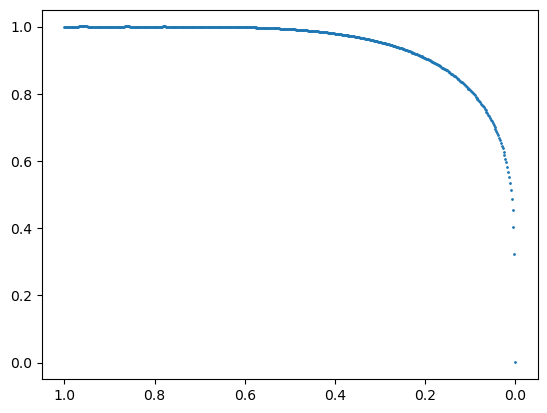

In [19]:
plt.scatter(sparsities, cum_weights[cats[0]],s=1)
plt.gca().invert_xaxis()
plt.show()

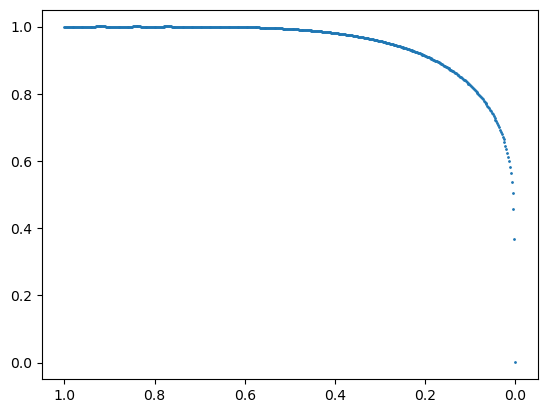

In [20]:
plt.scatter(sparsities, cum_weights[cats[1]],s=1)
plt.gca().invert_xaxis()
plt.show()

Empirically, feature preservation is not a perfect function of this cumulative score, its pretty noisy across different features, but these cumulative sparsity plots can be used to get an upper-bound on a feature-preserving circuit's size.

In [22]:
min_cum_score = .99

max_sparsities = {}
for cat in cats:
    for i in range(len(cum_weights[cat])-1,0,-1):
        if cum_weights[cat][i] < min_cum_score:
            break
    max_sparsities[cat] = round(sparsities[i-1],3)

NameError: name 'cum_weights' is not defined

In [22]:
max_sparsities

{'breakwater': 0.472, 'spider': 0.466}

#### Mask at different Sparsities 
Now we've done everything we can thats not tantamount to a time consuming search of different masks. From here, We'll just check feature activations at increasing sparsity levels and check feature preservation against our original activations (saved earlier). Ill use Pearson correlation as my 'loss' metric here (although this is probably a foul, as we are in the output layer and we should not expect the activations to be normally distributed). If you have a clear tolerance for your loss metric, you could proceed here with a binary search (mask the model, if performing better than tolerance, mask half of remaining weights, if performing worse, unmask half of previously masked, repeat . . .). Here we'll just mask the model linearly to smaller and smaller sizes and see what happens.

In [21]:
#First we have to inject a mask into our model. this setup function will insert a mask 
#next to each parameter in our model, such that the new model parameter is the old value
#multiplied by the mask value. We initialize the mask values at 1, keeping the network unchanged.
from circuit_pruner.simple_api.mask import setup_net_for_mask
setup_net_for_mask(model)

In [22]:
print(model.features[0].weight.shape)
print(model.features[0].weight_mask.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64, 3, 11, 11])


In [23]:
#now well iteratively change the mask value masking more and more low scoring weights, and save activations 
#from the resultant circuit
from circuit_pruner.simple_api.mask import mask_from_scores, apply_mask

circuit_activations = {}


#sparsities = {}

sparsities = np.linspace(.4,.01,5)



for cat in cats: 
    print(cat)
    
    circuit_activations[cat] = []
     #just test 3 sparsities, or this will take forever
    #sparsities[cat] = np.linspace(max_sparsities[cat],.01,5)

    #As before first we set up our target saver
    target_saver = feature_target_saver(model,target_layer,units[cat])
    
    for sparsity in sparsities:
    #for sparsity in sparsities[cat]:
        print(sparsity)
        
        #MASK THE MODEL
        mask = mask_from_scores(scores[cat],sparsity = sparsity)
        apply_mask(model,mask)
        
        activations = []
        #then we just run our data through the model, the target_saver will store activations for us
        for i, data in enumerate(dataloader, 0):

            inputs, target = data
            inputs = inputs.to(device)
            target = target.to(device)

            model.zero_grad() #very import!
            try:
                output = model(inputs)
            except TargetReached:
                pass


            #save activations
            activations.append(target_saver.target.detach().cpu().type(torch.FloatTensor))


        #turn batch-wise list into concatenated tensor
        activations = torch.cat(activations)
        circuit_activations[cat].append(activations)

    #we want to remove hooks for this category from our model
    target_saver.hook.remove()



breakwater
0.4
0.3025
0.20500000000000002
0.10750000000000004
0.01
spider
0.4
0.3025
0.20500000000000002
0.10750000000000004
0.01


In [24]:
correlations = {}

for cat in cats:
    correlations[cat] = []
    for a in circuit_activations[cat]: 
        correlations[cat].append(np.corrcoef(a,original_activations[cat])[0][1])



In [25]:
sparsities

array([0.4   , 0.3025, 0.205 , 0.1075, 0.01  ])

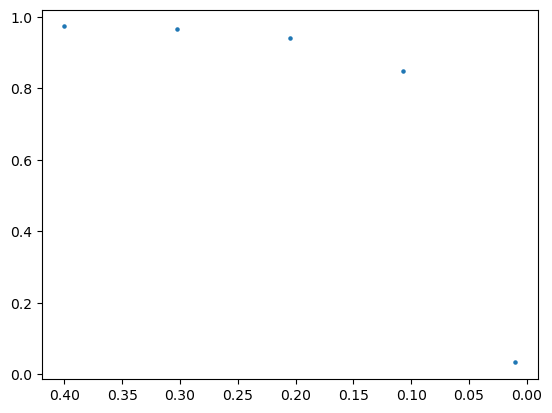

In [26]:
import matplotlib.pyplot as plt

plt.scatter(sparsities, correlations['spider'],s=5)
plt.gca().invert_xaxis()
plt.show()

In [27]:
correlations

{'breakwater': [0.9622806633395619,
  0.9484179716216964,
  0.9177796596862973,
  0.8278425633759204,
  0.044444139934289965],
 'spider': [0.9736035610021577,
  0.9657743017248553,
  0.9423181033270989,
  0.8476494552084184,
  0.03291861558971913]}

In [28]:
correlations

{'breakwater': [0.9773438811112968,
  0.9638051657187765,
  0.9338651613614857,
  0.859403379531012,
  0.45847053730843684],
 'spider': [0.9837427442308163,
  0.9770035674670229,
  0.9617621156078552,
  0.8991887408972105,
  0.41630374749324667]}

In [24]:
correlations

{'breakwater': [0.9459724856381325,
  0.9391344547906472,
  0.9261120325741165,
  0.8939161999626276,
  0.4883690006541154],
 'spider': [0.9581964275849573,
  0.9544806110431974,
  0.9460271256689314,
  0.9194129447282668,
  0.3942208627034051]}

In [29]:
correlations

{'breakwater': [0.9589732394486088,
  0.8923255004489925,
  0.7522973956255418,
  0.6145527523705752,
  0.5105736184753167],
 'spider': [0.9670889500702684,
  0.8858267071765049,
  0.6563184872361699,
  0.5185279547905604,
  0.5344095580138712]}

### circuit overlap
masks alone are sufficient to estimate circuit overlap

In [36]:
from circuit_pruner.simple_api.mask import mask_intersect_over_union


masks = {}


sparsities = {'breakwater':.5,
              'spider':.01}
for cat in cats:
    masks[cat] = mask_from_scores(scores[cat],sparsity = sparsities[cat])

from circuit_pruner.simple_api import mask_intersect_over_union

iou = mask_intersect_over_union(masks[cats[0]],masks[cats[1]])

In [37]:
iou = mask_intersect_over_union(masks[cats[0]],masks[cats[1]])

In [44]:
mask = mask_from_scores(scores['spider'],sparsity=.1)
apply_mask(model,mask)

In [47]:
model

Parameter containing:
tensor([[[[0., 0., 0.],
          [1., 1., 0.],
          [0., 1., 1.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[1., 0., 0.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [1., 1., 1.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 1., 1.],
          [0., 1., 0.],
        

In [40]:
#get architecture of circuits
for layer_name,mask in masks[cats[1]].items():
    print(layer_name)
    print(torch.sum(mask)/torch.numel(mask))


features.0
tensor(0.8049)
features.3
tensor(0.2917)
features.6
tensor(0.1694)
features.8
tensor(0.1578)
features.10
tensor(0.1443)
classifier.1
tensor(0.0002)
classifier.4
tensor(0.0085)
classifier.6
tensor(0.0036)


In [38]:
cats[0]

'breakwater'

In [44]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [27]:
correlations

{'snake': [0.9391416742471311, 0.9123192330526357, 0.21958079806214628],
 'spider': [0.9386553472223278, 0.9204697157109053, -0.01830562931161679]}

In [146]:
correlations

{'snake': [0.9332537952059453, 0.9113557669669585, 0.07405463957749338],
 'spider': [0.915265946945742, 0.8903017242148739, 0.18098042725051866]}